#Lab08-IT21207754

# Markov Decision Process (MDP)

### Ransalu Senanayake

In [28]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [29]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [30]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

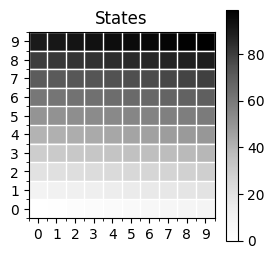

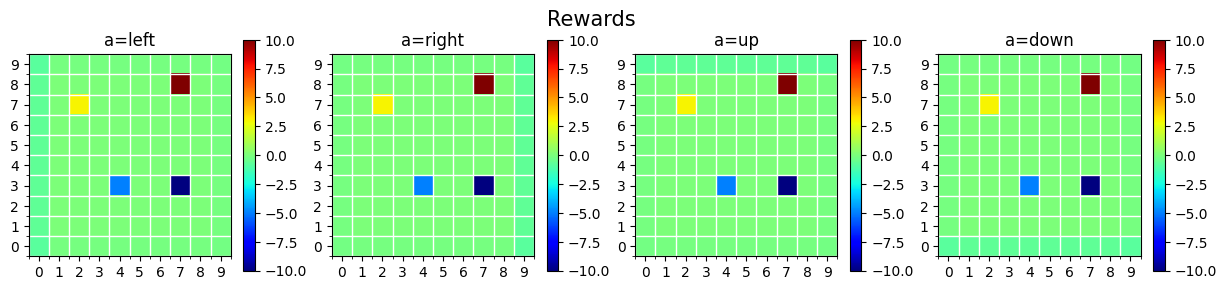

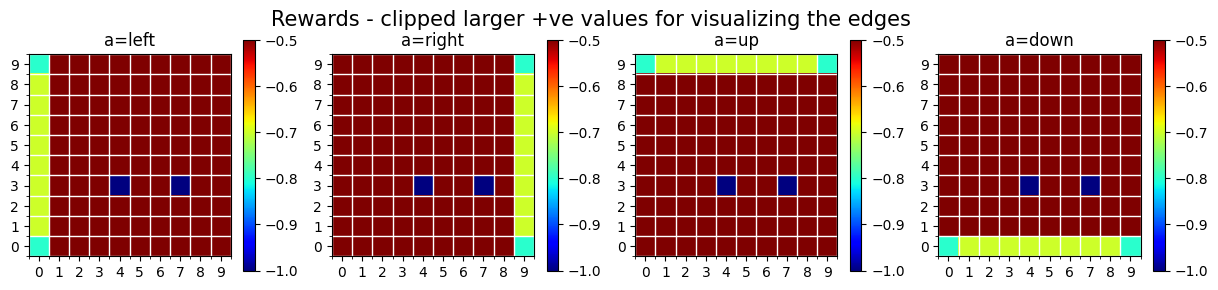

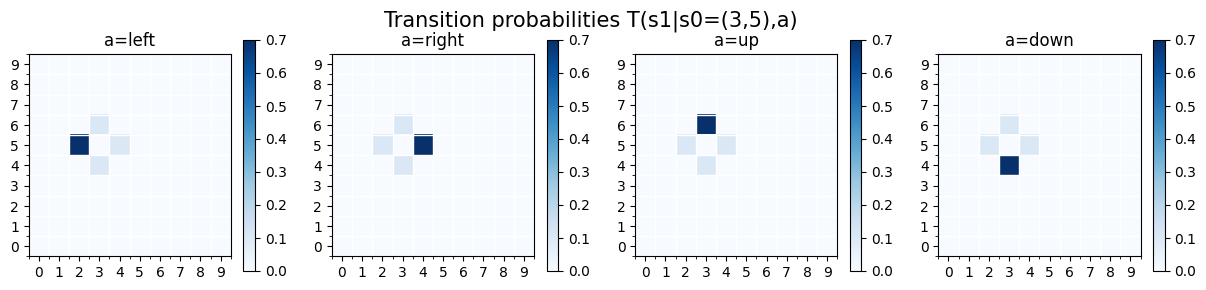

In [31]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [32]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

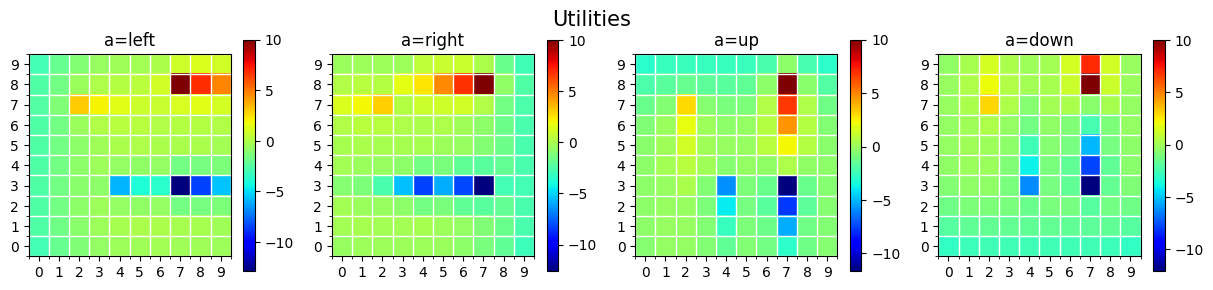

In [33]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      #type your code here
        for s0 in range(len(mdp.S)):
            U[s0] = mdp.R[s0,policy] + mdp.discount*sum([mdp.T[s0,policy,s1]*U_old[s1] for s1 in mdp.S])
            #U = map(s0 -> R(s0, policy(s0)) + discount*sum(s1 -> (T(s0, policy(s0), s1)*U[s1]), S), S)
            #U[s0] = mdp['R'][s0,policy] + mdp['discount']*np.sum(mdp['T'][s0,policy,:]*U_old[:])
        U_old = copy.copy(U)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [34]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

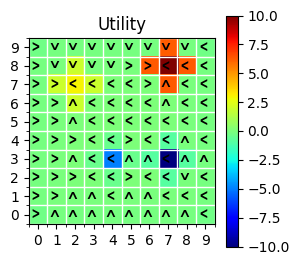

In [35]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        f#type your code here
        for s0 in range(len(mdp.S)):
            U[s0] = max([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_old[:]) for a in np.arange(len(mdp.A))])
        U_old = copy.copy(U)
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    #type your code here
    for s0 in range(len(mdp.S)):
        policy[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U[:]) for a in np.arange(len(mdp.A))])
    return policy


U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [36]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [37]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):

        #Policy evaluation: compute U_pi_k
          #type your code here
        U_pi_k_temp = copy.copy(U_pi_k)
        pi_k = copy.copy(pi_kp1)
        for s0 in range(len(mdp.S)):
            U_pi_k[s0] = mdp.R[s0,pi_k[s0]] + mdp.discount*np.sum(mdp.T[s0,pi_k[s0],:]*U_pi_k_temp[:])

        #Policy improvement
          #type your code here
        for s0 in range(len(mdp.S)):
            pi_kp1[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_pi_k[:]) for a in np.arange(len(mdp.A))])
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [38]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

#Q2

Value Iteration for the Model-Based approach.

Value Iteration converged at iteration 86
Value Iteration Time: 0.0147 seconds
Q-Learning Time: 0.4439 seconds


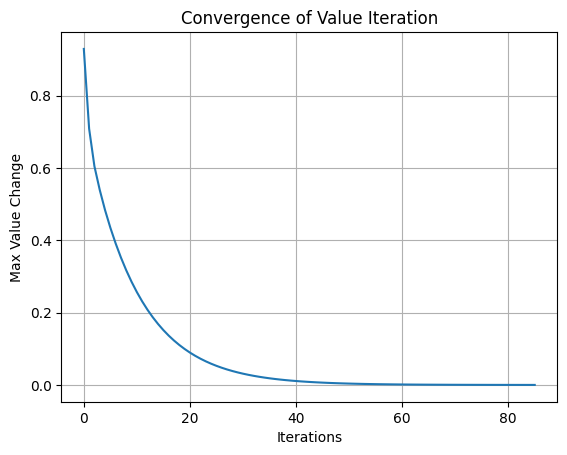

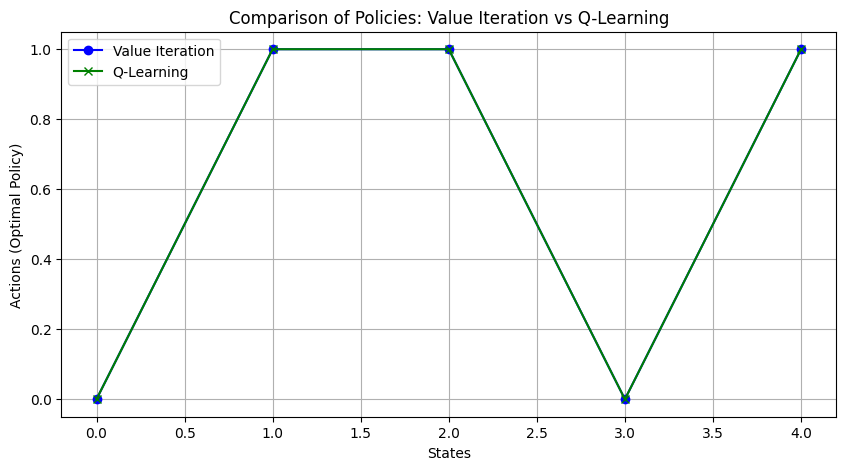

In [40]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Environment parameters
states = 5  # Number of states
actions = 2  # Number of actions
gamma = 0.9  # Discount factor
theta = 0.0001  # Convergence threshold
episodes = 1000  # For Q-learning
alpha = 0.1  # Learning rate for Q-learning
epsilon = 0.1  # Exploration rate for Q-learning

# Random rewards and transition probabilities
reward = np.random.rand(states, actions)  # Random rewards
transitions = np.random.rand(states, actions, states)  # Transition probabilities

# Normalize transition probabilities
for s in range(states):
    for a in range(actions):
        transitions[s, a, :] /= np.sum(transitions[s, a, :])

### Value Iteration (Model-Based Approach)
def value_iteration():
    value = np.zeros(states)  # Initialize value function
    policy = np.zeros(states, dtype=int)  # Initialize policy
    value_history = []  # Track value changes per iteration
    iterations = 0
    start_time = time.time()

    while True:
        delta = 0
        iterations += 1
        new_value = np.copy(value)
        for s in range(states):
            v = value[s]
            action_values = [sum([transitions[s, a, s1] * (reward[s, a] + gamma * new_value[s1]) for s1 in range(states)]) for a in range(actions)]
            best_action = np.argmax(action_values)
            value[s] = action_values[best_action]
            policy[s] = best_action  # Update policy to take the best action
            delta = max(delta, abs(v - value[s]))

        value_history.append(np.max(np.abs(value - new_value)))  # Track convergence changes

        if delta < theta:
            break

    end_time = time.time()
    print(f"Value Iteration converged at iteration {iterations}")

    return value, policy, iterations, value_history, end_time - start_time

### Q-Learning (Model-Free Approach)
def q_learning():
    Q = np.zeros((states, actions))
    policy = np.zeros(states, dtype=int)  # Initialize policy
    start_time = time.time()

    for episode in range(episodes):
        state = np.random.randint(0, states)  # Start from random state
        while True:
            # Epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.randint(0, actions)  # Explore
            else:
                action = np.argmax(Q[state, :])  # Exploit

            # Simulate environment step
            next_state = np.random.choice(states, p=transitions[state, action])
            reward_value = reward[state, action]

            # Q-value update
            Q[state, action] += alpha * (reward_value + gamma * np.max(Q[next_state, :]) - Q[state, action])

            if np.random.rand() < 0.1:  # Arbitrary stopping condition for this simulation
                break
            state = next_state

    # Derive policy from Q-table by taking the action with max Q-value for each state
    for s in range(states):
        policy[s] = np.argmax(Q[s, :])

    end_time = time.time()

    return Q, policy, end_time - start_time

### Plot Function: Compare Value Iteration and Q-Learning Policies
def plot_policies(policy_vi, policy_ql):
    states = range(len(policy_vi))  # Assuming both policies have the same number of states
    plt.figure(figsize=(10,5))
    plt.plot(states, policy_vi, label="Value Iteration", color='blue', marker='o')
    plt.plot(states, policy_ql, label="Q-Learning", color='green', marker='x')
    plt.legend()
    plt.title("Comparison of Policies: Value Iteration vs Q-Learning")
    plt.xlabel("States")
    plt.ylabel("Actions (Optimal Policy)")
    plt.grid(True)
    plt.show()

### Run Value Iteration and Q-Learning
value_iter_result, policy_vi, value_iter_iters, value_history, time_value_iter = value_iteration()
q_learning_result, policy_ql, time_q_learning = q_learning()

### Print Execution Times
print(f"Value Iteration Time: {time_value_iter:.4f} seconds")
print(f"Q-Learning Time: {time_q_learning:.4f} seconds")

### Visualize Value Iteration Convergence
plt.plot(range(value_iter_iters), value_history)
plt.title('Convergence of Value Iteration')
plt.xlabel('Iterations')
plt.ylabel('Max Value Change')
plt.grid(True)
plt.show()

### Plot Policy Comparison
plot_policies(policy_vi, policy_ql)


#q3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Episode: 0/10, Score: 10.0, Epsilon: 0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━

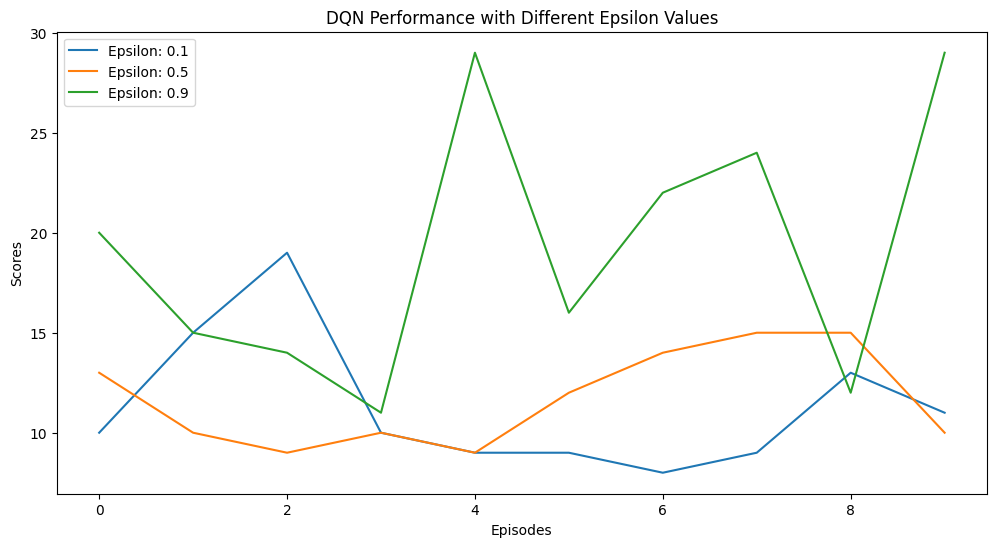

In [95]:
import numpy as np
import random
from collections import deque
import gym
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# DQN Parameters
EPISODES = 10  # Total episodes to train the agent
GAMMA = 0.95     # Discount rate for future rewards
EPSILON_START = 1.0  # Initial exploration rate
EPSILON_MIN = 0.1     # Minimum exploration rate
EPSILON_DECAY = 0.995  # Rate of decay for exploration
BATCH_SIZE = 32         # Batch size for experience replay

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size       # Size of the state space
        self.action_size = action_size     # Size of the action space
        self.memory = deque(maxlen=2000)   # Memory for storing experiences
        self.gamma = GAMMA                  # Discount factor for future rewards
        self.epsilon = EPSILON_START        # Exploration rate
        self.epsilon_min = EPSILON_MIN      # Minimum exploration rate
        self.epsilon_decay = EPSILON_DECAY  # Decay rate for exploration
        self.model = self._build_model()    # Build the Q-value model

    def _build_model(self):
        # Create a neural network for approximating Q-values
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))  # Input layer
        model.add(Dense(24, activation='relu'))      # Hidden layer with 24 neurons
        model.add(Dense(24, activation='relu'))      # Another hidden layer
        model.add(Dense(self.action_size, activation='linear'))  # Output layer
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Compile the model
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experiences in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Select an action using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        q_values = self.model.predict(state)  # Predict Q-values
        return np.argmax(q_values[0])  # Exploit (choose action with max Q-value)

    def replay(self):
        # Train the model using a random sample from memory
        if len(self.memory) < BATCH_SIZE:
            return  # If not enough samples, exit
        minibatch = random.sample(self.memory, BATCH_SIZE)  # Randomly sample a minibatch
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state)[0])  # Q-value for next state
            target_f = self.model.predict(state)  # Get current Q-values
            target_f[0][action] = target  # Update the target for the chosen action
            self.model.fit(state, target_f, epochs=1, verbose=0)  # Train the model
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay epsilon

# Training the DQN
def train_dqn(env, epsilon_values):
    results = {}
    for epsilon in epsilon_values:
        agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
        agent.epsilon = epsilon  # Set initial epsilon for this run
        scores = []

        # Loop over episodes
        for e in range(EPISODES):
            state = env.reset()  # Reset environment
            state = np.reshape(state, [1, agent.state_size])  # Reshape state
            score = 0

            # Loop for each time step in the episode
            for time in range(500):
                action = agent.act(state)  # Choose action
                next_state, reward, done, _ = env.step(action)  # Take action
                next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape next state
                agent.remember(state, action, reward, next_state, done)  # Store experience
                state = next_state  # Update current state
                score += reward  # Accumulate score

                if done:  # If episode is done, break
                    break

            agent.replay()  # Train agent with experiences
            scores.append(score)  # Record score

            # Print episode details
            if e % 10 == 0:  # Print every 10 episodes
                print(f'Episode: {e}/{EPISODES}, Score: {score}, Epsilon: {agent.epsilon:.2f}')

        results[epsilon] = scores  # Store scores for this epsilon

    return results

# Plotting Results
def plot_results(results):
    plt.figure(figsize=(12, 6))
    for epsilon, scores in results.items():
        plt.plot(range(EPISODES), scores, label=f'Epsilon: {epsilon}')  # Plot scores
    plt.title('DQN Performance with Different Epsilon Values')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

# Main
if __name__ == "__main__":
    env = gym.make('CartPole-v1')  # Create the CartPole environment
    epsilon_values = [0.1, 0.5, 0.9]  # Test different epsilon values
    results = train_dqn(env, epsilon_values)  # Train DQN agent
    plot_results(results)  # Plot results


 Import Necessary Libraries